In [1]:
# Configures the Environment (run it once)
include("configure.jl")

  Activating project at `/notebooks/notebooks`
   Resolving package versions...
  No Changes to `/notebooks/notebooks/Project.toml`
  No Changes to `/notebooks/notebooks/Manifest.toml`
Precompiling packages...
    672.6 ms  ✓ BlockDiagonals
    467.7 ms  ✓ BlockDiagonals → ChainRulesCoreExt
   2151.1 ms  ✓ Plots → UnitfulExt
  3 dependencies successfully precompiled in 4 seconds. 318 already precompiled.
   Resolving package versions...
  No Changes to `/notebooks/notebooks/Project.toml`
  No Changes to `/notebooks/notebooks/Manifest.toml`
   Resolving package versions...
  No Changes to `/notebooks/notebooks/Project.toml`
  No Changes to `/notebooks/notebooks/Manifest.toml`
   Resolving package versions...
  No Changes to `/notebooks/notebooks/Project.toml`
  No Changes to `/notebooks/notebooks/Manifest.toml`
   Resolving package versions...
  No Changes to `/notebooks/notebooks/Project.toml`
  No Changes to `/notebooks/notebooks/Manifest.toml`
   Resolving package versions...
  No Ch

# Configuration of the Quadrotor

In [1]:
include("Model_nd_Dynamics.jl")
include("Simulation.jl")
include("Trajectory.jl")
include("MPC.jl")
include("Close_loop.jl")

  Activating project at `/notebooks/notebooks`
  Activating project at `/notebooks/notebooks`
  Activating project at `/notebooks/notebooks`
  Activating project at `/notebooks/notebooks`
  Activating project at `/notebooks/notebooks`
  Activating project at `/notebooks/notebooks`


closed_loop

In [2]:
## Model Configs
#    g::Float64 # gravity
#    m::Float64 # mass
#    ℓ::Float64 # inter-propeller distance
#    J::Float64 # inertia momment
#    R::Float64 # propeller radius
#    prop_min_h::Float64 #
#    ρ::Float64 # GE correction factor (https://doi.org/10.1109/ChiCC.2015.7260521)
#    umin::Vector{Float64} # Thrust inferior limit
#    umax::Vector{Float64} # Thrust superior limit

model = Model(0.0, 0.0, 0.0, I(3), 0.0, 0.0, 0.0, zeros(4), zeros(4),0.0,0.0)
model.g = 9.81 # [m/s^2]
model.m = 0.5 # [kg]
model.ℓ = 0.1750 # [meters]
model.J = Diagonal([0.0023, 0.0023, 0.004]) # [kg . m^2]
model.R = 0.04 # [meters]
model.prop_min_h = 0.1 # [meters]
model.ρ = 1.0 # dimensionless
model.kt = 1.0
model.km = 0.0245

#Thrust limits
model.umin = 0.0 * model.m * model.g * ones(4)
model.umax = 2.0 * model.m * model.g * ones(4)

## Simulation Configs
#
# Universe 1000Hz
# Controlador 100Hz

h_universe = 0.0001 # Time step (10 kHz)
h_controller = 0.004 # Time step (200 Hz)
Tfinal = 10.0 # Simulate from 0 - 10 seconds

simulation = Simulation(h_universe, h_controller, Tfinal)

## Trajectory configuration
#mutable struct Trajectory
#    Amp::Float64    # Sine amplitude - [meters]
#    freq::Float64   # Sine frequency - [Hz]
#end

landing_start_height = 3.0
stationary_height = model.prop_min_h + 0.06 # 6 centimeters above the ground
plat_amplitude = 0.1
plat_freq = 0.3

traj_params = Trajectory(plat_amplitude, plat_freq, landing_start_height, stationary_height)

## Linear State Space Configs ???
#struct LinearStateSpace
#    Nx::Int64          # State vector dimension
#    Nu::Int64          # Control vector dimension
#    A::Matrix{Float64} # State Matrix
#    B::Matrix{Float64} # Control Matrix
#    x_hover::Float64   # x value for which the linearization was made
#    u_hover::Float64   # u value for which the linearization was made
Nx = 12
Nu = 4

#    function LinearStateSpace(model, simulation, Nx, Nu, height)
state_space = LinearStateSpace(model, simulation, Nx, Nu, landing_start_height)

## Tunning Parameters Configs
# mutable struct MPCTunningParameters
#    Nh::Int64           # Predictive horizon
#    Nc::Int64           # Control horizon (Nc < Nh)
#    Q::Matrix{Float64}  # Stage State Cost Penalty
#    R::Matrix{Float64}  # Stage Control Cost Penalty
#    Qn::Matrix{Float64} # Terminal State Cost Penalty
#end
Nh = 5
Nc = 42 # For now is unused...

# Cost weights
#Q = Array(10.0*I(Nx));
#Q[3,3] = 1000.0
#R = Array(.01*I(Nu));
#Qn = Array(1000.0*I(Nx));
Qn = Array(I(Nx));
Q = Array(I(Nx));
R = Array(.1*I(Nu));

tunning_params = MPCTunningParameters(Nh, Nc, Q, R, Qn)

## MPC Matrices Configs

#mutable struct MPCMatrices
#    P::Matrix{Float64}
#    U::Matrix{Float64}
#    Θ::Matrix{Float64}
#    H::SparseMatrixCSC{Float64,Int64}
#    b::Array{Float64,1}
#    C::SparseMatrixCSC{Float64,Int64}
#    Y::Matrix{Float64}
#    D::Array{Float64,1}
#    lb::Array{Float64,1}
#    ub::Array{Float64,1}

# function MPCMatrices(model, state_space, tunning_params, trajectory)
#mpc_mats =  MPCMatrices(model, state_space, tunning_params, traj_params)"

#x_ref = [0.0; 1.0; 0; 0; 0; 0]
# INITIAL STATE VECTOR - FULL ONE
theta = 10 * pi / 180  # 10 graus em rad
q0 = [cos(theta/2), sin(theta/2), 0.0, 0.0]
x0 = [1.0; 0.0; traj_params.init_heigth; q0 ; 0.0; 0.0; 0.0; 0.0; 0.0; 0.0]

#xhist1, uhist1 = closed_loop(x0, (t,x)->lqr_controller(t,x,K,x_ref), Nt);
#xhist2, uhist2 = closed_loop(x0, (t,x)->mpc_controller(t,x,x_ref), Nt);
xhist3, uhist3, plathist3, refyhist3, drefyhist3, land_time = closed_loop(
    x0,
    state_space,
    tunning_params, 
    traj_params,
    simulation,
    model,
    # mpc_controller(model, simulation, tunning_params, trajectory, t, x, xref)
    (t, x) -> mpc_controller(
        model,
        simulation,
        tunning_params,
        traj_params,
        t,
        x, 
        gen_ref(state_space, traj_params, tunning_params, t, simulation.h_controller) # verify if this works as expected!!
    )
);

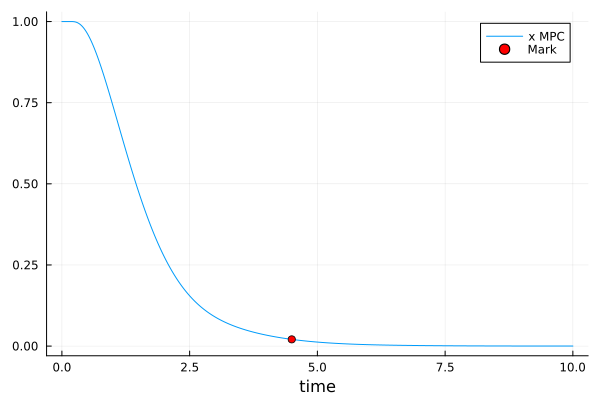

In [3]:
using Plots

thist = Array(range(0, simulation.h_universe * (simulation.Nt_universe - 1), step = simulation.h_universe));

# Define máximo de pontos que queremos exibir
max_points = 1000

# Calcula índice de salto (skip)
stride = max(1, floor(Int, length(thist) / max_points))

# Aplica o salto nos pontos
thist_sampled = thist[1:stride:end]
x_sampled = xhist3[1,1:stride:end]

# Plota linha reduzida
plot(thist_sampled, x_sampled, label="x MPC")

# Mantém o scatter do ponto especial
scatter!([land_time], [xhist3[1,trunc(Int, land_time/simulation.h_universe)]], label="Mark", color=:red, markersize=4)

xlabel!("time")

#savefig("Test01.svg")

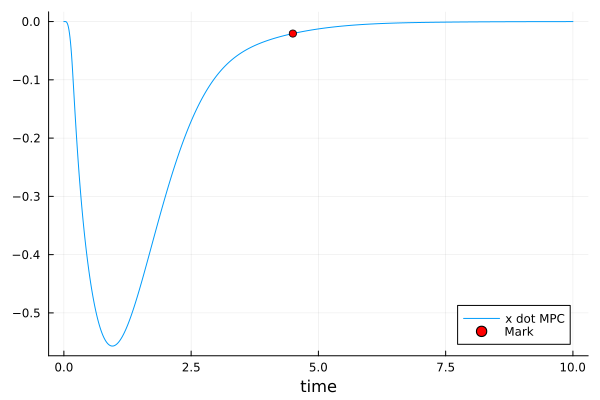

In [4]:
# Aplica o salto nos pontos
x_dot_sampled = xhist3[8,1:stride:end]

plot(thist_sampled, x_dot_sampled, label="x dot MPC")
scatter!([land_time], [xhist3[8,trunc(Int, land_time/simulation.h_universe)]], label="Mark", color=:red, markersize=4)

xlabel!("time")

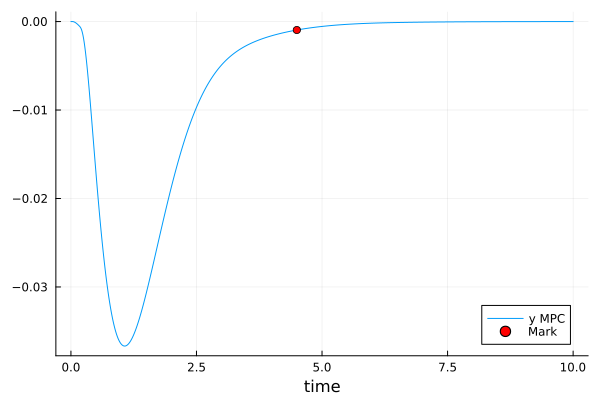

In [5]:
# Aplica o salto nos pontos
y_sampled = xhist3[2,1:stride:end]

plot(thist_sampled, y_sampled, label="y MPC")
scatter!([land_time], [xhist3[2,trunc(Int, land_time/simulation.h_universe)]], label="Mark", color=:red, markersize=4)

xlabel!("time")

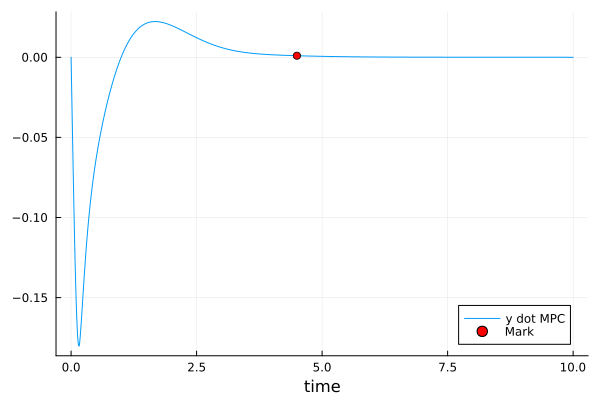

In [6]:
# Aplica o salto nos pontos
y_dot_sampled = xhist3[9,1:stride:end]

plot(thist_sampled, y_dot_sampled, label="y dot MPC")
scatter!([land_time], [xhist3[9,trunc(Int, land_time/simulation.h_universe)]], label="Mark", color=:red, markersize=4)

xlabel!("time")

In [7]:
# Aplica o salto nos pontos
#θ_sampled = xhist3[3,1:stride:end]

#plot(thist_sampled, θ_sampled, label="θ MPC")

#scatter!([land_time], [xhist3[3,trunc(Int, land_time/simulation.h_universe)]], label="Mark", color=:red, markersize=4)
#xlabel!("time")

In [8]:
# Aplica o salto nos pontos
#θ_dot_sampled = xhist3[6,1:stride:end]

#plot(thist, xhist3[6, :], label="θ dot MPC")
#scatter!([land_time], [xhist3[6,trunc(Int, land_time/simulation.h_universe)]], label="Mark", color=:red, markersize=4)

#xlabel!("time")

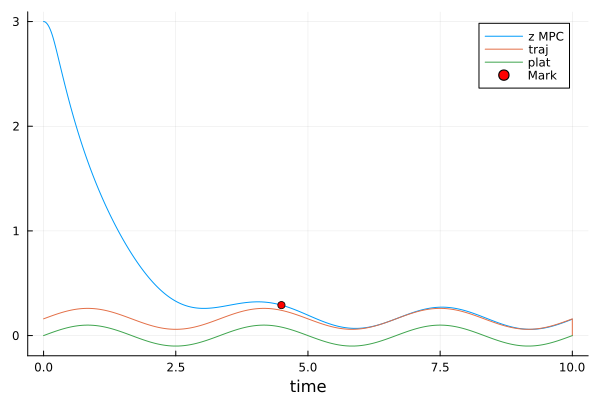

In [9]:
# Aplica o salto nos pontos
z_sampled = xhist3[3,1:stride:end]

## Plot de interesse
plot(thist_sampled, z_sampled, label="z MPC")

#plot!(thist, plathist3 .+ traj_params.stat_height, label=\"traj\")
plot!(thist, refyhist3, label="traj")
plot!(thist, plathist3, label="plat")

xlabel!("time")
scatter!([land_time], [xhist3[3,trunc(Int, land_time/simulation.h_universe)]], label="Mark", color=:red, markersize=4)

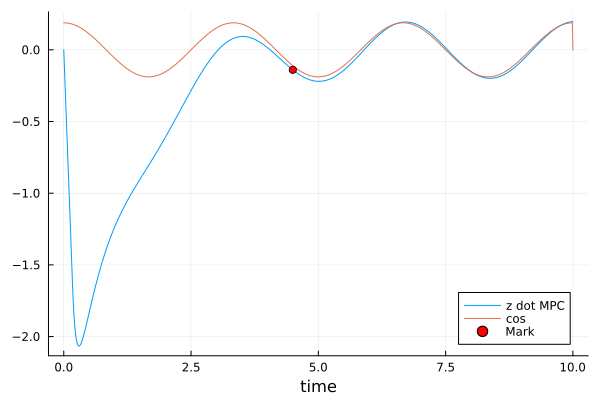

In [10]:
# Aplica o salto nos pontos
z_dot_sampled = xhist3[10,1:stride:end]
drefz_sampled = drefyhist3[1:stride:end]

plot(thist_sampled, z_dot_sampled, label="z dot MPC")
plot!(thist_sampled, drefz_sampled, label="cos")

xlabel!("time")
scatter!([land_time], [xhist3[10,trunc(Int, land_time/simulation.h_universe)]], label="Mark", color=:red, markersize=4)

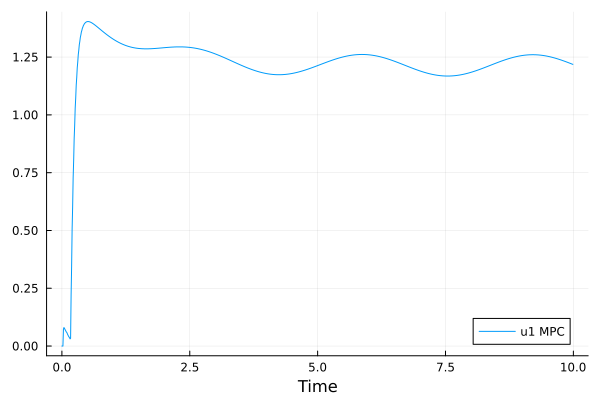

In [11]:
# Aplica o salto nos pontos
u1_sampled = uhist3[1,1:stride:end]

plot(thist_sampled[1:end-1], u1_sampled, label="u1 MPC")
xlabel!("Time")

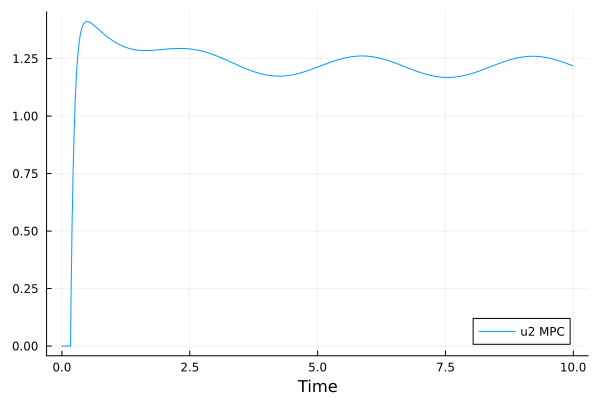

In [12]:
# Aplica o salto nos pontos
u2_sampled = uhist3[2,1:stride:end]

plot(thist_sampled[1:end-1], u2_sampled, label="u2 MPC")
xlabel!("Time")

In [13]:
# Aplica o salto nos pontos
u3_sampled = uhist3[3,1:stride:end]

plot(thist_sampled[1:end-1], u3_sampled, label="u2 MPC")
xlabel!("Time")

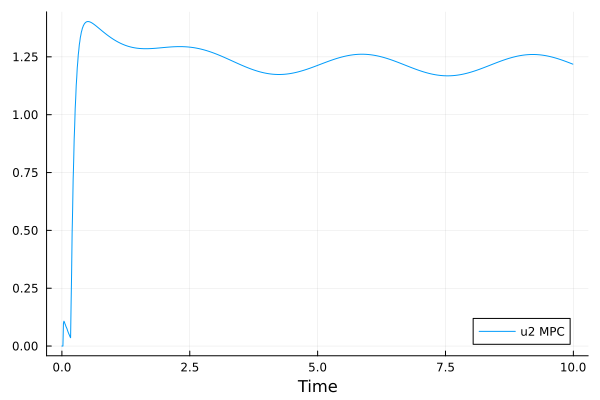

In [14]:
# Aplica o salto nos pontos
u4_sampled = uhist3[4,1:stride:end]

plot(thist_sampled[1:end-1], u4_sampled, label="u2 MPC")
xlabel!("Time")

In [15]:
#Set up visualization
using TrajOptPlots
using MeshCat
using StaticArrays
using RobotZoo:Quadrotor

vis = Visualizer()
render(vis)

┌ Info: MeshCat server started. You can open the visualizer by visiting the following URL in your browser:
└ http://127.0.0.1:8700


MeshCat.DisplayedVisualizer(MeshCat.CoreVisualizer(MeshCat.SceneTrees.SceneNode(nothing, nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}()), Set{Any}(), ip"127.0.0.1", 8700))

In [84]:
model = Quadrotor()
TrajOptPlots.set_mesh!(vis, model)

false

In [99]:
X1 = [SVector{13}(x) for x in eachcol(xhist3[:,1:10:end])];

visualize!(vis, model, thist[end], X1)